In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler,PolynomialFeatures
import seaborn as sns

%matplotlib inline

In [137]:
train_csv = ('train.csv')
test_csv = ('test.csv')
train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [138]:
def get_dummies(df):
    return pd.get_dummies(df[['Pclass','Embarked','Sex']])
get_dummies_tf =  FunctionTransformer(get_dummies, validate=False)

def base_features(df):
    return df[['SibSp']]
base_features_tf = FunctionTransformer(base_features, validate=False)

def high_fare_fifty(df):
    train['High Fare'] = train.loc[train['Fare'] >50,'Fare']
    return train[['High Fare']].fillna(0, inplace=True)
high_fare_fifty_tf = FunctionTransformer(high_fare_fifty, validate=False)
    

In [139]:
fu= FeatureUnion([
    ('get_dummies_tf', get_dummies_tf),
    ('base_features_tf',base_features_tf),
    
    
])
pipe = Pipeline([
    ('features',fu),
    ('poly', PolynomialFeatures())
])

In [140]:
X = pipe.fit_transform(train)
y= df_train['Survived']

In [141]:
kf = StratifiedKFold(random_state=2003)

In [142]:
cols = ['RF', 'SVC','LR']
shape = (train.shape[0], len(cols))
zeros =  np.zeros(shape)
stacked_train = pd.DataFrame(zeros, columns=cols, index=train.index)
stacked_train.head()

,RF,SVC,LR
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


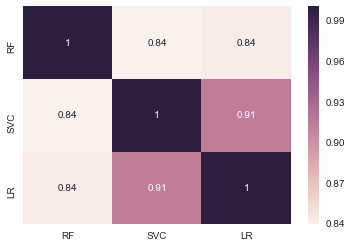

In [157]:

for train_indices, test_indices in kf.split(X,y):
    X_train = X[train_indices,:]
    X_test =X[test_indices,:]
    y_train = y[train_indices]
    y_test = y[test_indices]
        
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    stacked_train.loc[test_indices, 'LR']=pred
    
    svc = SVC()
    svc.fit(X_train, y_train)
    pred = svc.predict(X_test)
    stacked_train.loc[test_indices, 'SVC']=pred
    
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    stacked_train.loc[test_indices, 'RF']=pred
    
    
sns.heatmap(stacked_train.corr(), annot=True)


In [158]:
stacked_model = GradientBoostingClassifier()
params = {}
gs = GridSearchCV(stacked_model, param_grid=params)
gs.fit(stacked_train, y)
gs.best_score_


0.79349046015712688

In [159]:
test_p =  pipe.transform(test)

In [160]:
lr = LogisticRegression()
svc = SVC()
rf = RandomForestClassifier()
lr.fit(X,y)
svc.fit(X,y)
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [165]:
cols = ['RF', 'SVC','LR']
shape = (test.shape[0], len(cols))
zeros =  np.zeros(shape)
stacked_test = pd.DataFrame(zeros, columns=cols, index=test.index)
stacked_test.head()

stacked_test['LR']=lr.predict(test_p)
stacked_test['SVC']=svc.predict(test_p)
stacked_test['RF']=rf.predict(test_p)
stacked_test.head()

,RF,SVC,LR
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [169]:
pred = gs.predict(stacked_test)
test['Survived'] = pred
test[['PassengerId','Survived']].to_csv('final.csv', index=False)